In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## 1. KNN Imputation and Classification

### a.

In [92]:
df1 = pd.read_csv('DodgerLoopGame\DodgerLoopGame_TRAIN.txt',sep="\s+",header=None)
df2 = pd.read_csv('DodgerLoopGame\DodgerLoopGame_TEST.txt',sep="\s+",header=None)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,1.0,2.0,8.0,7.0,6.0,2.0,8.0,5.0,10.0,3.0,...,11.0,7.0,12.0,4.0,9.0,13.0,3.0,5.0,5.0,3.0
1,1.0,8.0,5.0,10.0,11.0,9.0,10.0,7.0,18.0,11.0,...,13.0,7.0,6.0,7.0,1.0,2.0,6.0,7.0,8.0,6.0
2,1.0,1.0,9.0,5.0,2.0,5.0,5.0,5.0,13.0,6.0,...,10.0,5.0,14.0,9.0,13.0,10.0,9.0,5.0,11.0,6.0
3,1.0,2.0,6.0,6.0,3.0,8.0,6.0,3.0,4.0,3.0,...,8.0,13.0,9.0,11.0,10.0,4.0,6.0,6.0,3.0,10.0
4,1.0,8.0,6.0,5.0,11.0,7.0,4.0,10.0,8.0,8.0,...,19.0,13.0,15.0,17.0,10.0,8.0,12.0,16.0,15.0,13.0


In [96]:
NaTrain = df1.isna().sum().sum()
NaTest = df2.isna().sum().sum()
print('Numberof NaN values in Train Datasets are',NaTrain)
print('Numberof NaN values in Test Datasets are',NaTest)

Numberof NaN values in Train Datasets are 65
Numberof NaN values in Test Datasets are 272


### b. KNN Imputer

In [98]:
from sklearn.impute import KNNImputer
from scipy.spatial.distance import cdist

impute = KNNImputer(n_neighbors=3)

# Train Dataset
df1_imput = impute.fit_transform(df1)
df1_imputed = pd.DataFrame(df1_imput, columns=df1.columns)

# Test Dataset
df2_imput = impute.fit_transform(df2)
df2_imputed = pd.DataFrame(df2_imput, columns=df2.columns)

print("\nTrain Dataset Number of NaN values after Imputation:", df1_imputed.isna().sum().sum())
print("\nTest Dataset Number of NaN values after Imputation:", df2_imputed.isna().sum().sum())

#mse = mean_squared_error(df2_imput, df2_imputed)
#print(mse)


Train Dataset Number of NaN values after Imputation: 0

Test Dataset Number of NaN values after Imputation: 0


In [146]:
from sklearn.impute import KNNImputer
from scipy.spatial.distance import cdist

def knn_imputer_grid_search(X_train, X_test, k_values):
    best_k = 1
    best_mean_distance = float('inf')
    
    for k in k_values:
    
        imputer = KNNImputer(n_neighbors=k)
        train_imputed = imputer.fit_transform(X_train)
        test_imputed = imputer.transform(X_test)
        # Checking shapes to see if it aligns or not ..
      #  print("Shape of imputed values after flattening:", np.isnan(imputed_values).sum())
        
       # distances = cdist(original_values_without_nan.reshape(-1, 1), imputed_values.reshape(-1, 1), metric='euclidean')
        distances = cdist(train_imputed, test_imputed, metric='euclidean') # calculating the  pairwise Euclidean distance
        mean_distance = np.mean(distances) # Getting the mean distances

        print(f"K={k}, Mean Distance={mean_distance:.4f}")

        # Update the best K if current mean distance is lower
        if mean_distance < best_mean_distance:
            best_mean_distance = mean_distance
            best_k = k
            
    print(f"Optimal number of neighbors (K): {best_k}")    # Using the best K to impute both train and test datasets
    print(f"Best Mean Distance: {best_mean_distance:.4f}")

    # Final imputation with the best K
    final_imputer = KNNImputer(n_neighbors=best_k)
    # Using the best k for the input data
    train_imputed = pd.DataFrame(final_imputer.fit_transform(X_train), columns=X_train.columns)
    # test_imputed = pd.DataFrame(final_imputer.transform(X_test), columns=X_test.columns  # To perform imputation on the test data here

    return best_k

k_values = [1, 3, 5, 7, 9]
optimal_k = knn_imputer_grid_search(df1, df2,k_values)
print(f"Optimal K: {optimal_k}")


K=1, Mean Distance=179.2819
K=3, Mean Distance=178.9790
K=5, Mean Distance=178.8261
K=7, Mean Distance=178.8077
K=9, Mean Distance=178.7810
Optimal number of neighbors (K): 9
Best Mean Distance: 178.7810
Optimal K: 9


In [ ]:
###### ### KNN Inputer from scratch

import numpy as np

def manhattan_distance(a, b):
    """Calculate the Manhattan distance between two points."""
    return np.sum(np.abs(a - b))

def knn_impute(data, k):
    """
    Impute missing values in the dataset using KNN.
    
    Parameters:
    - data: 2D numpy array with missing values as np.nan.
    - k: Number of nearest neighbors to use for imputation.

    Returns:
    - A numpy array with missing values imputed.
    """
    data_imputed = data.copy()
    n_rows, n_cols = data.shape

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            if np.isnan(data[row_idx, col_idx]):
                # Find rows with non-missing values for the current column
                valid_rows = [i for i in range(n_rows) if not np.isnan(data[i, col_idx])]

                # If no valid rows exist, leave the missing value as is
                if not valid_rows:
                    continue

                # Calculate distances to other rows based on non-missing features
                distances = []
                for valid_row in valid_rows:
                    # Only compare non-missing features
                    mask = ~np.isnan(data[row_idx, :]) & ~np.isnan(data[valid_row, :])
                    if np.any(mask):  # Ensure there is at least one feature to compare
                        distance = manhattan_distance(data[row_idx, mask], data[valid_row, mask])
                        distances.append((distance, valid_row))

                # Sort by distance and take k nearest neighbors
                distances.sort(key=lambda x: x[0])
                k_nearest = distances[:k]

                # Impute the missing value as the mean of the neighbors' values in the current column
                k_values = [data[neighbor[1], col_idx] for neighbor in k_nearest]
                data_imputed[row_idx, col_idx] = np.mean(k_values)

    return data_imputed

def main_knn_imputer():
    # Generate synthetic dataset with missing values
    np.random.seed(42)
    data = np.random.rand(10, 5)
    data[1, 2] = np.nan
    data[3, 0] = np.nan
    data[7, 4] = np.nan
    print("Original Data with Missing Values:")
    print(data)

    # Impute missing values using KNN
    k = 3
    data_imputed = knn_impute(data, k)

    print("\nData after KNN Imputation:")
    print(data_imputed)

# Run the main function
main_knn_imputer()


### c. KNN Classifier

In [273]:
def train_val_test_split(X,y):
    # Calculate the split indices
    split_train_idx = int(len(data) * 0.7)  # 70% for training
    split_temp_idx = int(len(data) * 0.85)  # 85% for training + validation (so 15% remains for testing)
    
    # Split the data into training, validation, and test sets
    train_data = data[:split_train_idx]      # First 70% for training
    validation_data = data[split_train_idx:split_temp_idx]  # Next 15% for validation
    test_data = data[split_temp_idx:]    # Last 15% for testing


    train_data = data[:split_train_idx]      # First 70% for training
    validation_data = data[split_train_idx:split_temp_idx]  # Next 15% for validation
    test_data = data[split_temp_idx:]
    
    return train_data, validation_data, test_data


def train_test_split(data, test_size=0.2):
   
    split_idx = int(len(data) * (1 - test_size))
    
    # Split the data into train and test sets
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    
    return train_data, test_data


In [178]:
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def EuclideanDistance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def y_prediction(k_neighbors, y_train):
    y_pred = [y_train[i] for i in k_neighbors]
    return Counter(y_pred).most_common(1)[0][0] # Return the most common label (majority voting)

def predict_knn_class(x_train, y_train, k, z): # KNN for classification
    distances = []
    
    for i in range(len(x_train)): # We need to Calculate the Euclidean distance from the test point (z) to all points in the training set
        distance = EuclideanDistance(z, x_train[i])
        distances.append((i, distance))  # Storing the index and corresponding distance

    distances.sort(key=lambda x: x[1])
    k_neighbors = [distances[i][0] for i in range(k)]  # taking indices of the k nearest neighbors
    
    return y_prediction(k_neighbors, y_train)  #  majority voting prediction

def grid_search_knn(X, y, k_values): # Function to perform grid search for finding optimal K value

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_k = None
    best_accuracy = 0

    for k in k_values:  # Trying different values of K and checking
        y_train_pred = []
        for i in range(len(X_train)):
            y_train_pred.append(predict_knn_class(X_train, y_train, k, X_train[i]))  # Get predictions for training set

        accuracy_train = accuracy_score(y_train, y_train_pred)

        y_test_pred = []  # Predict for the test set
        for i in range(len(X_test)):
            y_test_pred.append(predict_knn_class(X_train, y_train, k, X_test[i]))  # Getting test set predictions

        accuracy_test = accuracy_score(y_test, y_test_pred) 

    
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_k = k

        print(f"K={k}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")

    print(f"Optimal K: {best_k}")
    print(f"Best Test Accuracy with K={best_k}: {best_accuracy:.4f}")

    return best_k, best_accuracy

def main_knn_example():
    
    # Creating dataset (500 rsamples, 5 features)  ## There were no target columns in the dodgr loop dataset
    np.random.seed(42)
    X = np.random.rand(500, 5)  # 
    y = np.random.randint(0, 2, 500)  # 0 or 1

    k_values = [1, 3, 5, 7, 9]  # Perform grid search over different K values
    grid_search_knn(X, y, k_values)

main_knn_example()


K=1, Train Accuracy: 1.0000, Test Accuracy: 0.5100
K=3, Train Accuracy: 0.7750, Test Accuracy: 0.4500
K=5, Train Accuracy: 0.6875, Test Accuracy: 0.5100
K=7, Train Accuracy: 0.6175, Test Accuracy: 0.4800
K=9, Train Accuracy: 0.5800, Test Accuracy: 0.5400
Optimal K: 9
Best Test Accuracy with K=9: 0.5400


In [171]:
df1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,1.0,7.0,3.0,6.0,11.0,8.0,6.0,6.0,10.0,4.0,...,12.0,5.0,9.0,4.0,4.0,6.0,9.0,5.0,16.0,8.0
1,1.0,9.0,10.0,5.0,7.0,10.0,9.0,5.0,6.0,8.0,...,8.0,5.0,4.0,8.0,6.0,11.0,5.0,8.0,9.0,6.0
2,1.0,12.0,18.0,11.0,11.0,19.0,17.0,4.0,6.0,8.0,...,10.0,9.0,11.0,8.0,4.0,7.0,3.0,6.0,3.0,6.0


In [169]:
## df1.iloc[1] #better for numpy

0       1.0
1       9.0
2      10.0
3       5.0
4       7.0
       ... 
284    11.0
285     5.0
286     8.0
287     9.0
288     6.0
Name: 1, Length: 289, dtype: float64

In [2]:
### Voronoi tesselation (Decision boundary)

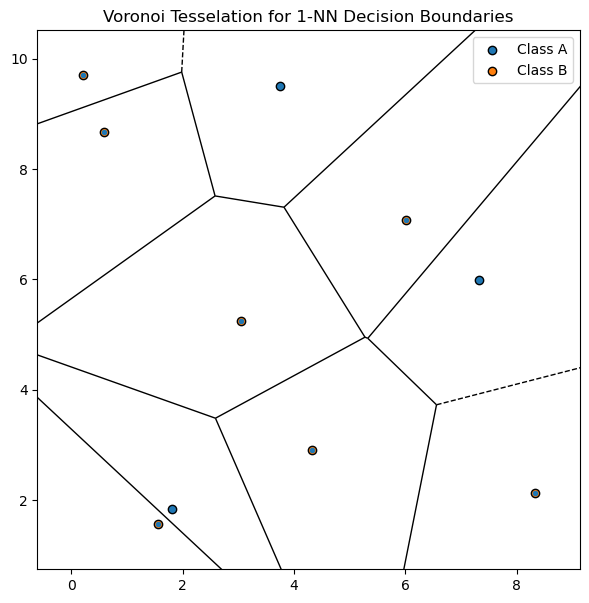

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import KNeighborsClassifier

# Generate random 2D points (training data)
np.random.seed(42)
X_train = np.random.rand(10, 2) * 10  # 10 points in 2D space
y_train = np.random.choice(['A', 'B'], size=10)  # Two class labels

# Train a 1-NN classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Compute Voronoi diagram
vor = Voronoi(X_train)

# Plot Voronoi tessellation
fig, ax = plt.subplots(figsize=(7, 7))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black')

# Scatter plot of training points
for label in np.unique(y_train):
    mask = y_train == label
    ax.scatter(X_train[mask, 0], X_train[mask, 1], label=f"Class {label}", edgecolor='k')

plt.legend()
plt.title("Voronoi Tesselation for 1-NN Decision Boundaries")
plt.show()


In [ ]:
########### Implementing Kfold cross validation to find the optimal value of k using error minimization

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generate synthetic dataset
X, y = make_classification(n_samples=500, n_features=5, n_classes=2, n_informative=3, n_redundant=2, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement K-Fold Cross-Validation to find the optimal K for KNN
k_values = range(1, 21)  # Checking K values from 1 to 20
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

error_rates = []

for k in k_values:
    fold_errors = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Train KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_fold, y_train_fold)
        
        # Predict on validation fold
        y_val_pred = knn.predict(X_val_fold)
        
        # Compute error rate (1 - accuracy)
        fold_error = 1 - accuracy_score(y_val_fold, y_val_pred)
        fold_errors.append(fold_error)
    
    # Store mean error across folds for this K value
    error_rates.append(np.mean(fold_errors))

# Find optimal K (with the lowest error rate)
optimal_k = k_values[np.argmin(error_rates)]
optimal_error = min(error_rates)

# Plot error rates vs K values
plt.figure(figsize=(10, 5))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed', color='b', label="Error Rate")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal K={optimal_k}")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Error Rate")
plt.title("K-Fold Cross-Validation for Optimal K in KNN")
plt.legend()
plt.grid(True)
plt.show()

# Train final model with optimal K
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)
y_test_pred = final_knn.predict(X_test)

# Compute final accuracy on test data
final_accuracy = accuracy_score(y_test, y_test_pred)

# Display results
final_knn_results_df = pd.DataFrame({
    "Parameter": ["Optimal K", "Final Test Accuracy"],
    "Value": [optimal_k, final_accuracy]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Optimal KNN Results", dataframe=final_knn_results_df)




#####another solu

def EuclideanDistance(a,b):
    return np.sqrt(np.sum((a-b)**2))
    
def y_prediction(x,y,k):
    y_pred=[]
    for k,v in x:
        y_pred.append(y[k,0])
    return Counter(y_pred).most_common(1)[0][0]

def y_prediction(x,y,k):
    y_pred=[]
    for k,v in x:
        y_pred.append(y[k,0])
    return Counter(y_pred).most_common(1)[0][0]

def predict_knn_reg(x,y,k,z):
    d=dict()
    for i in range(0,len(x)):
        d[i]=EuclideanDistance(z,x.iloc[i])
    d_new=sorted(d.items(),key=lambda kv:kv[1])
    c=d_new[:k]
    y_pred=y_prediction(c,y,k)
    return y_pred

def data_k_divide(data,k):
    k_size=Math.floor(len(data)/k)
    k_data=[] 
    c=0
    for i in range (0,k):
        data_set=pd.DataFrame(data.head(0))
        for j in range(i*k_size,(i*k_size)+k_size):
            data_set=data_set.append(data.iloc[j])
            c=c+1
        k_data.append(data_set)
        
    #adding datas which are remaining at the end of k division
    for j in range(c,len(data)):
        k_data[k-1]=k_data[k-1].append(data.iloc[j])
    return k_data

def k_data_train_test(x,y,k):
    k_folded_data=[]
    for i in range(0,k):
        x_test=x[i]
        y_test=y[i]
        x_train=pd.DataFrame()
        y_train=pd.DataFrame()
        for j in range(0,k):
            if i!=j:
                x_train=x_train.append(x[j])
                y_train=y_train.append(y[j])
        final_data=dict([('x',x_train),('y',y_train),('xt',x_test),('yt',y_test)])
        k_folded_data.append(final_data)
    return k_folded_data

def kfold(x_train,y_train,k):
    x_train_k=data_k_divide(x_train,k)
    y_train_k=data_k_divide(y_train,k)
    data=k_data_train_test(x_train_k,y_train_k,k)
    accuracy=[]
    for i in range(len(data)):
        y_pred=[]
        for j in range(0,len(data[i]['xt'])):
            y_pred.append(predict_knn_reg(data[i]['x'],data[i]['y'].values,k,data[i]['xt'].iloc[j].values))
        accuracy.append(classification_accuracy(data[i]['yt'],y_pred))
    return accuracy


def classification_accuracy(y,y_pred):
    y=pd.DataFrame(y).to_numpy()
    y_pred=np.asarray(y_pred)
    acc=np.mean(y == y_pred)
    return acc


ypred_v=[]
k=5
for j in range(0,len(x_test_rwine)):
    ypred_v.append(predict_knn_reg(x_train_rwine,y_train_rwine.values,k,x_test_rwine.iloc[j].values))


best_accuracy=0
best_k=0
accuracyall=[]
for i in range (2,15): #using k values between 2 to 15
    kr=kfold(x_train_rwine,y_train_rwine,i)
    if(len(accuracyall)==0 or np.average(kr)>best_accuracy):
        best_k=i
        best_accuracy=np.average(kr)
    accuracyall.append(np.average(kr))
    print('for value of k=',i,' ','best k=',best_k,'best_accuracy=',best_accuracy)
print('best average accuracy=',best_accuracy)
print('best k=',best_k) 

fig,axs=plt.subplots(1,1,figsize=(20,10))
axs.plot(np.arange(len(accuracyall)),accuracyall)
axs.plot(np.arange(len(accuracyall)),accuracyall,'o')
plt.show()




### 2. Decision Trees

In [3]:
df3 = pd.read_csv('iris\iris.data',header=None)
df3[4].value_counts()

4
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [192]:
# df4 = pd.get_dummies(df3, columns=[4], drop_first=True)
# df4.head()

,0,1,2,3,4_Iris-versicolor,4_Iris-virginica
0,5.1,3.5,1.4,0.2,False,False
1,4.9,3.0,1.4,0.2,False,False
2,4.7,3.2,1.3,0.2,False,False
3,4.6,3.1,1.5,0.2,False,False
4,5.0,3.6,1.4,0.2,False,False


In [4]:
df3[4] = df3[4].map({'Iris-setosa':'0', 'Iris-versicolor':'1', 'Iris-virginica':'2'})
df3[4] = df3[4].astype(float)
df3.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
x = df3.drop(columns=4)
y = df3[4]

#### a) Class for Tree Node

In [6]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature  
        self.threshold = threshold  
        self.left = left  
        self.right = right  
        self.value = value  # Predicted value for leaf nodes

    def is_leaf_node(self):
        return self.value is not None


#### b) Functions to build the Tree using RSS as the criterion

In [7]:
def rss(y):
    if len(y) == 0:  # Handle empty data
        return 0
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1]
        self.root = self._grow_tree(X, y)

    # def predict(self, X):
    #     return np.array([self._traverse_tree(x, self.root) for x in X])
        
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        # Stopping criteria
        if (depth >= self.max_depth or n_samples < self.min_samples_split):
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # Growing the children
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)


    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._calculate_rss(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh


    def _calculate_rss(self, y, X_column, split_thresh):
        
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        
        # If no split (empty subset), return infinity to avoid it
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return float("inf")
        
        rss_left = rss(y[left_idxs])
        rss_right = rss(y[right_idxs])

        return rss_left + rss_right

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
    
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            print(f"Warning: One of the splits is empty (threshold: {split_thresh}).")
        return left_idxs, right_idxs


    # def _traverse_tree(self, x, node):
    #     if node.is_leaf_node():
    #         if node.value is None:
    #             print("error: leaf node value is None")
    #             raise ValueError("leaf node has no value.")
    #         return node.value
    
    #     if node.feature is None or node.threshold is None:
    #         print("Error: Node feature or threshold is None")
    #         raise ValueError("Node feature or threshold is None during traversal.")
    
    #     print(f"Traversing node: feature {node.feature}, threshold {node.threshold}, value {node.value}")
    #     if x[node.feature] <= node.threshold:
    #         return self._traverse_tree(x, node.left)
    #     return self._traverse_tree(x, node.right)

 

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

# x = np.array(x)
# y = np.array(y).flatten()
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# clf = DecisionTree(max_depth=10)
# clf.fit(X_train, y_train)

#  # Make predictions on the test set
# y_pred = clf.predict(X_test)

# mse = clf.mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)



#### c) Transversing the tree and making predictions

In [12]:
def _traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)


def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

# if __name__ == "__main__":
#     # Load the Iris dataset
#     iris = load_iris()
#     X, y = iris.data, iris.target
#     y = y.astype(float)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the decision tree regressor
#     tree = DecisionTree(min_samples_split=3, max_depth=10)
#     tree.fit(X_train, y_train)

#     # Make predictions and evaluate
#     y_pred = tree.predict(X_test)
#     mse = tree.mean_squared_error(y_test, y_pred)
#     print(f"Mean Squared Error on test set: {mse:.4f}")

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # should set a n_features_in_ attribute at fit time to indicate the number of features that the estimator expects for 
        #subsequent calls to predict or transform
        self.n_features_in_ = X.shape[1]
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        
        data = np.c_[X, y]
        
        self.tree_ = Decision_Tree(name="root", level=0, max_depth=self.max_depth)
        self.tree_.expand_decision_tree(data)
        
        # Return the classifier
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError('Shape of input is different from what was seen in `fit`')
        
        return self.tree_(X)

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(CustomDecisionTreeClassifier())

class Decision_Tree():
    def __init__(self, name="root", level=0, max_depth=None, log=False):
        self.log = log
        self.name = name
        self.is_leaf = False
        self.level = level
        self.max_depth = max_depth
        
    def __call__ (self , X, log=False):
        if self.is_leaf:
            return np.full(len(X), self.value)
        else:

            split_rule = X[:, self.split_column].astype(float) < self.split_value #generate the array of boolean values with shape(X.shape[0], 1)
            self_left_result = self.left(X[split_rule])
            
            if len(self_left_result)>0 and isinstance(self_left_result[0], str):
                #y_pred = np.full(len(X), "")
                y_pred = np.empty((len(X)), dtype=np.dtype('U100'))
            else:
                y_pred = np.full(len(X), np.nan)
            
            self_right_result = self.right(X[~split_rule])
            
            y_pred[split_rule] = self_left_result
            y_pred[~split_rule] = self_right_result
            
            return y_pred
        
    def expand_decision_tree(self, data):
        if(self.log):
            print(self.name + " - Going to start growing")
            print(self.name + " - Number samples: " + str(data.shape[0]))
        
        if(self.stopping_criterion(data)):
            #It's a leaf, all remaining data falls under this leaf
            self.is_leaf = True
            self.value = self.classify(data)
            if(self.log):
                print(self.name + " - Value:", self.value)
            return self
        
        #It's not a leaf, the tree keeps growing
        
        #TODO
        candidate_splits = self.get_candidate_splits(data)
        if(self.log):
            print(self.name + " - candidate_splits:", candidate_splits)
        self.split_column, self.split_value = self.get_best_split(data, candidate_splits)
        self.value = "< " + str(self.split_value)
        if(self.log):
            print(self.name + " - self.split_column:", self.split_column)
            print(self.name + " - self.split_value:", self.split_value)
        data_below, data_above = self.split_data(data, self.split_column, self.split_value)
        if(self.log):
            print(self.name + " - data_below:\n", data_below)
            print(self.name + " - data_above:\n", data_above)
        self.left = Decision_Tree(name=self.name + " - " + str(self.level+1) + "-left", level=self.level+1, max_depth=self.max_depth).expand_decision_tree(data_below)
        self.right = Decision_Tree(name=self.name + " - " + str(self.level+1) + "-right", level=self.level+1, max_depth=self.max_depth).expand_decision_tree(data_above)
        
        return self
        
    def learn_from_data(self, data):
        self.expand_decision_tree(data)
            
    def stopping_criterion(self, data):
        if self.max_depth != None and self.level + 1 == self.max_depth:
            if(self.log):
                print(self.name + " - Has reached max levels:", self.max_depth)
            return True
        
        #If there is only one left node or all remaining nodes belong to one class, this is a leaf
        class_column = data[:, -1]
        if(self.log):
            print(self.name + " - Has only one element:", data.shape[0] == 1)
            print(self.name + " - Only one class:", len(np.unique(class_column)) == 1)
        
        if data.shape[0] == 1 or len(np.unique(class_column)) == 1:
            return True
        else:
            return False
        
    def classify(self, data):
        class_column = data[:, -1]
        unique_classes, unique_classes_counts = np.unique(class_column, return_counts=True)
        
        index_majority_class =np.argmax(unique_classes_counts)
        class_value = unique_classes[index_majority_class]
        return class_value
    
    def get_candidate_splits(self, data):
        candidate_splits = {}
        features = data.shape[1] - 1 # remove last class column
        if(self.log):
            print(self.name + " - features:", features)
        for feature_idx in np.arange(features):
            candidate_splits[feature_idx] = []
            feature_unique_values = np.unique(data[:, feature_idx])
            if(self.log):
                print(self.name + " - Feature [", feature_idx, "] feature_unique_values:", feature_unique_values)
            for idx in np.arange(1, len(feature_unique_values)):
                prev_val = feature_unique_values[idx - 1]
                curr_val = feature_unique_values[idx]
                candidate_split = (float(curr_val) + float(prev_val))/2
                
                candidate_splits[feature_idx].append(candidate_split)
                
        return candidate_splits
    
    def split_data(self, data, split_column, split_value):
        split_column_values = data[:, split_column].astype(float)

        data_below = data[split_column_values < split_value]
        data_above = data[split_column_values >=  split_value]

        return data_below, data_above
    
    def get_best_split(self, data, candidate_splits):
        best_information_gain = 0
        # select the split rule value according to the quality criterion
        for feature_idx in candidate_splits:
            for split in candidate_splits[feature_idx]:
                data_below, data_above = self.split_data(data, feature_idx, split)
                if(self.log):
                    print(self.name + " - Evaluate split:", split)
                curr_information_gain = self.calculate_information_gain(data_below, data_above)
                if(self.log):
                    print(self.name + " - Feature [", feature_idx, "] split [", split, "] curr_information_gain:", curr_information_gain)
                if curr_information_gain > best_information_gain:
                    best_information_gain = curr_information_gain
                    best_split_column = feature_idx
                    best_split_value = split
                
        return best_split_column, best_split_value
        #return 0, 6.1
    
    def calculate_information_gain(self, data_below, data_above):
        if(self.log):
            print(self.name + " - data_below.shape:", data_below.shape)
            print(self.name + " - data_above.shape:", data_above.shape)
        sum_of_matrix = len(data_below) + len(data_above)
        cj_left = len(data_below)  #number of samples of row left
        cj_right = len(data_above) #number of samples of row right
        
        _, cjk_left = np.unique(data_below[:,-1], return_counts=True) #vector with number of samples per each class of row left
        _, cjk_right = np.unique(data_above[:,-1], return_counts=True) #vector with number of samples per each class of row right
        
        class_column = np.concatenate((data_below,data_above),axis=0)[:,-1]
        _, ck = np.unique(class_column, return_counts=True) #vector with number of samples per each class
        
        if(self.log):
            print(self.name + " - sum_of_matrix:", sum_of_matrix)
            print(self.name + " - cj_left:", cj_left)
            print(self.name + " - cj_right:", cj_right)
            print(self.name + " - cjk_left:", cjk_left)
            print(self.name + " - cjk_right:", cjk_right)
            print(self.name + " - ck:", ck)
        
        information_gain =  -sum(ck/sum_of_matrix * np.log2(ck/sum_of_matrix)) \
                            + cj_left/sum_of_matrix  * sum(cjk_left/cj_left * np.log2(cjk_left/cj_left)) \
                            + cj_right/sum_of_matrix * sum(cjk_right/cj_right * np.log2(cjk_right/cj_right))
                                                           
        if(self.log):
            print(self.name + " - information_gain", information_gain)
        return information_gain
        

In [ ]:
def normalize(X):
    #normalization
    sc = StandardScaler()

    # apply normalization to cont cols of subset
    X = sc.fit_transform(X)
    #print(sc.mean_)
    
    return X

#Read Iris data
iris_dataset= datasets.load_iris()
X = iris_dataset.data
y = iris_dataset.target
X = normalize(X)
print("Samples:", X.shape)
print("Target:", y.shape)
print("Target Classes:")
print(list(iris_dataset.target_names))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

custom_cfl = CustomDecisionTreeClassifier()
custom_cfl.fit(X_train, y_train)
y_pred = custom_cfl.predict(X_test)
print("Custom DecisionTreeClassifier")
print("Accuracy", accuracy_score(y_test, y_pred))
print("Number of correctly classified samples:", accuracy_score(y_test, y_pred, normalize=False), "/", len(y_test))


In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=2023)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Sklearn DecisionTreeClassifier")
print("Accuracy", accuracy_score(y_test, y_pred))
print("Number of correctly classified samples:", accuracy_score(y_test, y_pred, normalize=False), "/", len(y_test))

In [ ]:
bc_dataset= datasets.load_breast_cancer()
X = bc_dataset.data
y = bc_dataset.target
X = normalize(X)
print("Samples:", X.shape)
print("Target:", y.shape)
print("Target Classes:")
print(list(bc_dataset.target_names))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

**Decision Trees**

In this part, you need to implement a decision tree for classification. 

- Implement an object class **"Decision_Tree"** with learn and predict methods. The class should work with multiple **Quality-criterion**. (Accuracy, Information Gain, Misclassification Rate (MCR)) 
- Implement appropriate stopping criterion i.e. max depth, gain is too small, minimum number of samples for splitting. You can have one or more stopping criterias.
- Download and read the Nursery dataset. Link: https://archive.ics.uci.edu/ml/datasets/Nursery
- Once the data is loaded, split the data into 70-20-10 split for train/validation/test. *(You can use sklearn for splitting the dataset)*
- Train your **"Decision_Tree"** with different hyperparameters
    - Perform either grid or random search. *(You can use sklearn for hyperparameter search)*
    - Hyperparameters can include max-depth, minimunm gain for splitting, minimum number of samples for splitting. Quality-criterion must be one of the hyperparameter. 
    - Compare the results on validation data. 
    - Report the test results for the best model. 
    - Print the best tree using a breath first tree traversal (only till depth of 4).

In [ ]:
#reading the data
df = pd.read_csv("nursery_data.txt")
#splitting into X and y columns and encoding the target labels
X, y = df.iloc[:,:-1],df.iloc[:,-1]
target_encoder = LabelEncoder()
y_transformed = target_encoder.fit_transform(y)

#splitting based on train, valid, test ratios
train_ratio = 0.70 
validation_ratio = 0.20
test_ratio = 0.10

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=1 - train_ratio, random_state=3116)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=3116) 


#make dataframes of all the training, validation and test sets
y_train = pd.DataFrame(y_train,index=X_train.index)
y_test = pd.DataFrame(y_test,index=X_test.index)
y_valid = pd.DataFrame(y_valid,index=X_valid.index)


### Write your code here

class Node:
    """
    Class which represents a simple node in a decision tree.
    """
    def __init__ (self, probs=None, feature=None, condition=None, left_subtree=None, right_subtree=None, leaf_val=None):
        # Probability of an instance belonging to different classes
        self.probs = probs
        # The feature which the node checks
        self.feature = feature
        # The condition or threshold
        self.condition = condition
        # Left subtree of the node
        self.left_subtree = left_subtree
        # Right subtree of the node
        self.right_subtree = right_subtree
        # Leaf value that the node has
        self.leaf_val = leaf_val

class DecisionTreeClf:
    """
    Decision Tree Classifier Class which implements the Decision tree based on MCR as a quality criterion and Information Gain.
    """
    def __init__ (self, criterion, max_depth, min_samples_per_leaf, classes_name, tolerance=0.01):
        # Maximum depth to which the tree can grow
        self.max_depth = max_depth
        # Minimum number of samples in each node
        self.min_samples_per_leaf = min_samples_per_leaf
        # Root node
        self.root = None
        # Criterion, can be MCR or Entropy
        self.criterion = criterion
        # Names of classes which the data represents
        self.classes_name = classes_name
        # List to store gains at each decision step, useful for visualizations
        self.best_gains = []
        # Stopping criteria when gain is too small or reduction in cost is small
        self.tolerance = tolerance

    def fit(self, X, y):
        # It is important to know the types of columns
        self.cat_types = self.cols_cat_list(X)
        # Number of classes in the data
        self.num_cats = np.max(np.unique(y)) + 1
        # Concatenating data and target as they are easier to deal with
        data = pd.concat([X, y], axis=1)
        # Growing the tree from the root node
        self.root = self.grow_tree(data)

    def predict(self, X):
        # List to store predictions
        preds = []
        # Iterating over one row at a time
        for _, x in X.iterrows():
            # Storing the predictions for each observation
            preds.append(self.forward_traverse(x, self.root)[0])
        return preds

    def misclassification_rate(self, y):
        # Initialize the empty vector which represents the probability of each class
        pred = np.zeros(self.num_cats)
        # Count the number of unique classes
        val, counts = np.unique(y, return_counts=True)
        # Set the count as the initial prediction (in the next step, this will be converted to probability)
        pred[val] = counts
        # Convert the count into probability and return the negative MCR
        probs = pred / np.sum(pred)
        return -(1 - np.max(probs))

    def entropy(self, y):
        # To calculate the information gain, the entropy function will be useful
        class_labels = np.unique(y)
        entropy = 0
        # Iterate over each class and calculate its entropy
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def information_gain(self, parent, left_y, right_y):
        # Weight of left and right nodes
        weight_l = len(left_y) / len(parent)
        weight_r = len(right_y) / len(parent)
        # Quality criterion as MCR and Information gain are handled differently
        if self.criterion == "MCR":
            return weight_l * self.misclassification_rate(left_y) + weight_r * self.misclassification_rate(right_y)
        elif self.criterion == "Entropy":
            return self.entropy(parent) - (weight_l * self.entropy(left_y) + weight_r * self.entropy(right_y))

    def split_data(self, data, feature, condition):
        # Get the datatype of the presented feature
        data_type = data[feature].dtype
        # Numeric and categoric columns are handled differently
        if data_type == 'O':
            left_data = data[data[feature] == condition]
            right_data = data[data[feature] != condition]
        else:
            left_data = data[data[feature] < condition]
            right_data = data[data[feature] >= condition]
        return left_data, right_data

    def get_leaf_value(self, y):
        # Initialize the empty probability vector
        pred = np.zeros(self.num_cats)
        # Count unique ys
        val, counts = np.unique(y, return_counts=True)
        # Set the count to the probability vector
        pred[val] = counts
        # Convert counts into probability
        probs = pred / np.sum(pred)
        return probs

    def cols_cat_list(self, data):
        # This function helps in separating categoric columns from numeric ones
        col_types = {}
        for col in data.columns:
            if data[col].dtype == 'O':
                col_types[col] = 'cat'
            else:
                col_types[col] = 'num'
        return col_types

    def best_split(self, data):
        # Dictionary to store information about the best split
        best_split = {}
        # Since we want to maximize the gain, start with the smallest number
        best_gain = -np.inf
        # Start iterating over each column, one by one till the target
        for feat in data.columns[:-1]:
            # Numeric and categorical column will be handled differently
            data_type = data[feat].dtype
            # For categorical features
            if data_type == 'O':
                v = np.unique(data[feat])
                # Iterate over each unique value
                for cond in v:
                    # Splitting the data based on the current value
                    left_data, right_data = self.split_data(data, feat, cond)
                    # Avoid unnecessary splits
                    if len(left_data) > 0 and len(right_data) > 0:
                        # Get the labels of each dataset
                        data_y, left_y, right_y = data.iloc[:, -1], left_data.iloc[:, -1], right_data.iloc[:, -1]
                        # Calculate the quality criterion/information gain of the current split
                        gain = self.information_gain(data_y, left_y, right_y)
                        # Store the information of the best split
                        if gain > best_gain:
                            best_gain = gain
                            best_split['feature'] = feat
                            best_split['condition'] = cond
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
            # For numeric features
            else:
                v = sorted(list(set(data[feat])))
                # Arrange all the unique numeric column into ascending order
                means = [(v[i] + v[i + 1]) / 2 for i in range(len(v) - 1)]
                # Check on each threshold of the mean of entries
                for mean in means:
                    # Splitting the data
                    left_data, right_data = self.split_data(data, feat, mean)
                    # Avoid unnecessary splits
                    if len(left_data) > 0 and len(right_data) > 0:
                        # Get the labels of each dataset
                        data_y, left_y, right_y = data.iloc[:, -1], left_data.iloc[:, -1], right_data.iloc[:, -1]
                        # Calculate the quality criterion/information gain of the current split
                        gain = self.information_gain(data_y, left_y, right_y)
                        # Store the information of the best split
                        if gain > best_gain:
                            best_gain = gain
                            best_split['feature'] = feat
                            best_split['condition'] = mean
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
        return best_split

    def grow_tree(self, data, curr_depth=0):
        # Separate the labels
        labels = data.iloc[:, -1]
        # Count the unique labels in the target set
        n_labels = len(np.unique(labels))
        # Count the number of samples in the data
        samples = data.shape[0]
        # Get the empty vector to store probabilities
        probs = np.zeros(self.num_cats)
        p = labels.value_counts() / labels.value_counts().sum()
        # Get the probability of each class
        for i, v in p.items():
            probs[i] = v
        # Checking the stopping condition
        if samples < self.min_samples_per_leaf or n_labels == 1 or curr_depth > self.max_depth:
            return Node(probs, leaf_val=np.argmax(self.get_leaf_value(data.iloc[:, -1])))
        # If stopping condition is not met, then we will split the data based on the best split
        best_split = self.best_split(data)
        feat = best_split['feature']
        condition = best_split['condition']
        gain = best_split['gain']
        left_data = best_split['left_data']
        right_data = best_split['right_data']
        # Check for early stopping based on the tolerance
        if (len(self.best_gains) > 1) and np.abs(gain - self.best_gains[-1]) < self.tolerance:
            return Node(probs, leaf_val=np.argmax(self.get_leaf_value(data.iloc[:, -1])))
        else:
            self.best_gains.append(gain)
        # Adds left and right nodes recursively
        left_subtree = self.grow_tree(left_data, curr_depth + 1)
        right_subtree = self.grow_tree(right_data, curr_depth + 1)
        return Node(probs, feat, condition, left_subtree, right_subtree)

    def forward_traverse(self, data, node):
        # Check if the current node is the leaf node
        if node.leaf_val is not None:
            return node.leaf_val, node.probs
        # If it's a decision node
        feat = node.feature
        cond = node.condition
        left_subtree = node.left_subtree
        right_subtree = node.right_subtree
        # Check the datatype of the feature
        data_type = self.cat_types[feat]
        # For categoric feature
        if data_type == 'cat':
            if data[feat] == cond:
                return self.forward_traverse(data, left_subtree)
            return self.forward_traverse(data, right_subtree)
        # For numeric feature
        else:
            if data[feat] < cond:
                return self.forward_traverse(data, left_subtree)
            return self.forward_traverse(data, right_subtree)

    def plot_histogram(self, node=None):
        # This function plots the histogram at each decision split
        if node is None:
            node = self.root
        if node.leaf_val is not None:
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilities at Leaf Node")
            plt.bar(self.classes_name, node.probs)
            plt.show()
        else:
            feat = node.feature
            cond = node.condition
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilities at Decision {feat} == {cond}")
            plt.bar(self.classes_name, node.probs)
            plt.show()
            self.plot_histogram(node.left_subtree)
            self.plot_histogram(node.right_subtree)

    def print_tree(self, node=None, indent=1, max_depth=4):
        # To print the tree
        if node is None:
            node = self.root
        if node.leaf_val is not None or indent > max_depth:
            print(f"Leaf Node Value: {self.classes_name[np.argmax(node.leaf_val)]}")
        else:
            feat = node.feature
            cond = node.condition
            print(f"Decision: {node.feature} == {node.condition}")
            print("|" * indent + "left :", end="")
            self.print_tree(node.left_subtree, indent + 1, max_depth)
            print("|" * indent + "right:", end="")
            self.print_tree(node.right_subtree, indent + 1, max_depth)

    def calculate_loss(self, x, y):
        # Calculate the loss of each sample
        loss = []
        for i in range(len(x)):
            # Calculate the cross entropy loss of each sample
            loss.append(np.log(self.forward_traverse(x.iloc[i, :], self.root)[1][y.iloc[i, :]][0] + 1e-12))
        return -np.sum(loss) / len(loss)

    def plot_information_gain(self):
        # Plot the information gain
        plt.figure()
        plt.xlabel("Split Number")
        plt.ylabel("Information Gain")
        plt.title(f"Plot of Information Gain at each Decision")
        plt.plot(np.arange(len(self.best_gains)), self.best_gains)
        plt.show()



class TreeRandomSearchCV:
    def __init__(self, config):
        # Configuration dictionary for hyperparameters
        self.config = config

    def run(self, num_trials, X_data, y_data, X_valid, y_valid):
        # Initialize best loss, best accuracy, best model, and best hyperparameters
        best_loss = np.inf
        best_acc = -np.inf
        best_model = None
        best_params = None

        for _ in range(num_trials):
            # Run the training function to get validation accuracy, loss, random configuration, and model
            val_acc, val_loss, rand_config, model = self.training_function(X_data, y_data, X_valid, y_valid)

            # Update the best parameters if the current trial performs better
            if val_loss < best_loss:
                best_loss = val_loss
                best_acc = val_acc
                best_params = rand_config
                best_model = model

        return best_acc, best_loss, best_params, best_model

    def random_select(self):
        # Randomly select hyperparameters from the configuration dictionary
        rand_config = {}

        for k, v in self.config.items():
            m = len(v)
            r_val = v[np.random.randint(0, m)]
            rand_config[k] = r_val

        return rand_config

    def training_function(self, X_data, y_data, X_valid, y_valid):
        # Randomly select hyperparameters
        rand_config = self.random_select()

        # Extract hyperparameters
        max_depth = rand_config["max_depth"]
        min_samples_per_leaf = rand_config["min_samples_per_leaf"]
        tolerance = rand_config["tolerance"]
        criterion = rand_config["criterion"]
        # Assuming target_encoder is defined elsewhere
        classes_name = target_encoder.classes_

        # Print the selected hyperparameters
        print(f"Currently Selected Params are criterion: {criterion}, max_depth: {max_depth}, min_samples_per_leaf: {min_samples_per_leaf}, gain_tolerance: {tolerance}")

        # Initialize and train the DecisionTreeClf model
        model = DecisionTreeClf(criterion, max_depth, min_samples_per_leaf, classes_name, tolerance)
        model.fit(X_data, y_data)

        # Make predictions on the validation set
        preds = model.predict(X_valid)
        # Calculate accuracy and loss
        acc_score = accuracy_score(y_valid, preds)
        loss = model.calculate_loss(X_valid, y_valid)

        # Print validation accuracy and loss
        print(f'The Validation Accuracy is {acc_score} and Validation loss is {loss}\n')

        return acc_score, loss, rand_config, model



config = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_per_leaf": [1, 2, 4, 8],
    "tolerance": [0.1, 0.01, 0.001],
    "criterion": ["MCR", "Entropy"]
}

NUM_TRIALS = 10 #number of times the random search has to be performed
random_search = TreeRandomSearchCV(config)
best_acc, best_loss, best_params, best_model = random_search.run(NUM_TRIALS, X_train, y_train, X_valid, y_valid)

# To print the tree using breath first tree traversal till depth of 4
best_model.print_tree(max_depth=4)

#to plot information gain at each decision step
best_model.plot_information_gain()







############## USING GINI INDEX

import numpy as np

class DecisionTreeGini:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def gini(self, y):
        """
        Compute the Gini Impurity for a given set of labels y.
        Gini = 1 - sum(p_i^2)
        """
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def best_split(self, X, y):
        """
        Find the best feature and threshold to split on using Gini Impurity.
        """
        best_gini = float("inf")
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                left_gini = self.gini(y[left_mask])
                right_gini = self.gini(y[right_mask])
                weighted_gini = (np.sum(left_mask) * left_gini + np.sum(right_mask) * right_gini) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree using the best Gini split.
        """
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return np.argmax(np.bincount(y))

        best_feature, best_threshold = self.best_split(X, y)
        if best_feature is None:
            return np.argmax(np.bincount(y))

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return {"feature": best_feature, "threshold": best_threshold, "left": left_subtree, "right": right_subtree}

    def fit(self, X, y):
        """
        Train the decision tree.
        """
        self.tree = self.build_tree(X, y)

    def predict_sample(self, sample, tree):
        """
        Predict the class label for a single sample.
        """
        if isinstance(tree, dict):
            if sample[tree["feature"]] <= tree["threshold"]:
                return self.predict_sample(sample, tree["left"])
            else:
                return self.predict_sample(sample, tree["right"])
        else:
            return tree

    def predict(self, X):
        """
        Predict labels for all samples in X.
        """
        return np.array([self.predict_sample(sample, self.tree) for sample in X])


# Example Usage
X_example = np.array([[7.2, 0], [6.4, 0], [5.9, 1], [5.0, 1]])  # Wingspan, Species
y_example = np.array([0, 1, 0, 1])  # Female (0), Male (1)

# Train Decision Tree
tree = DecisionTreeGini(max_depth=2)
tree.fit(X_example, y_example)

# Predict on the training set
y_pred_example = tree.predict(X_example)

# Display tree structure and predictions
tree_structure = tree.tree
prediction_results = pd.DataFrame({"True Label": y_example, "Predicted Label": y_pred_example})

import ace_tools as tools
tools.display_dataframe_to_user(name="Decision Tree Predictions", dataframe=prediction_results)



wingspan species sex
7.2ft bald eagle female
6.4ft bald eagle male
5.9ft osprey female
5.0ft osprey male

Construct a decision tree (without explicit training) which realizes the partition shown in Figure 1.
B. [4p] Given the data from Table 1, train by hand a Decision Tree Classifier that predicts the sex of a bird
given its wingspan and species. Use the Gini-Index as the splitting criterion. Draw the learned tree.
C. [2p] Find and draw a minimal depth Decision Tree that solves the classification problem from 1B

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Given dataset (Table 1)
wingspan = np.array([7.2, 6.4, 5.9, 5.0]).reshape(-1, 1)  # Feature: Wingspan
species = np.array([0, 0, 1, 1])  # Bald eagle (0), Osprey (1) as numerical labels
sex = np.array([0, 1, 0, 1])  # Female (0), Male (1)

# Combining features (Wingspan + Species)
X = np.column_stack((wingspan, species))
y = sex  # Target: Sex

# Train a Decision Tree Classifier using Gini Index
tree_model = DecisionTreeClassifier(criterion="gini", max_depth=2)
tree_model.fit(X, y)

# Plot the Decision Tree
plt.figure(figsize=(8, 5))
plot_tree(tree_model, feature_names=["Wingspan", "Species"], class_names=["Female", "Male"], filled=True)
plt.title("Minimal Depth Decision Tree")
plt.show()


In [ ]:
# Implementing Jaccard Similarity and Hamming Distance

def jaccard_similarity(set1, set2):
    """
    Compute Jaccard Similarity between two sets.
    Jaccard Similarity = |Intersection| / |Union|
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def hamming_distance(str1, str2):
    """
    Compute Hamming Distance between two strings of equal length.
    Hamming Distance = Count of positions where characters differ
    """
    if len(str1) != len(str2):
        raise ValueError("Strings must be of the same length for Hamming distance")

    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

# Example Usage
set_a = {"apple", "banana", "cherry"}
set_b = {"banana", "cherry", "date", "fig"}
jaccard_score = jaccard_similarity(set_a, set_b)

str1 = "karolin"
str2 = "kathrin"
hamming_dist = hamming_distance(str1, str2)

# Display results
distance_results_df = pd.DataFrame({
    "Metric": ["Jaccard Similarity", "Hamming Distance"],
    "Value": [jaccard_score, hamming_dist]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Similarity and Distance Metrics", dataframe=distance_results_df)


###### Your task is to implement a function called levenshtein_dist, that takes two input strings and calculates the distance between them. Ultimately, you need to find the Levenshtein distance 

In [ ]:
def levenshtein_dist(s1, s2):
    """
    Compute the Levenshtein distance between two strings using dynamic programming.
    The Levenshtein distance is the minimum number of single-character edits (insertions, deletions, or substitutions)
    required to change one string into the other.
    """
    len_s1, len_s2 = len(s1), len(s2)
    
    # Initialize distance matrix
    dp = np.zeros((len_s1 + 1, len_s2 + 1), dtype=int)

    # Fill the base case values
    for i in range(len_s1 + 1):
        dp[i][0] = i  # Cost of deleting all characters
    for j in range(len_s2 + 1):
        dp[0][j] = j  # Cost of inserting all characters

    # Compute Levenshtein distance
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            if s1[i - 1] == s2[j - 1]:  # Characters are the same
                cost = 0
            else:  # Characters are different (substitution cost = 1)
                cost = 1

            dp[i][j] = min(dp[i - 1][j] + 1,      # Deletion
                           dp[i][j - 1] + 1,      # Insertion
                           dp[i - 1][j - 1] + cost)  # Substitution

    return dp[len_s1][len_s2]

# Example usage
string1 = "kitten"
string2 = "sitting"

levenshtein_result = levenshtein_dist(string1, string2)

# Display result
results_df = pd.DataFrame({
    "Metric": ["Levenshtein Distance"],
    "Value": [levenshtein_result]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Levenshtein Distance Result", dataframe=results_df)


In [ ]:
###### We will now implement the Manhattan, Euclidian and Chebyshev distance metrics 

# Implement Manhattan Distance
def manhattan_distance(p1, p2):
    """
    Compute the Manhattan distance between two points.
    Manhattan Distance = sum(|x_i - y_i|)
    """
    return np.sum(np.abs(np.array(p1) - np.array(p2)))

# Implement Euclidean Distance
def euclidean_distance(p1, p2):
    """
    Compute the Euclidean distance between two points.
    Euclidean Distance = sqrt(sum((x_i - y_i)^2))
    """
    return np.sqrt(np.sum((np.array(p1) - np.array(p2)) ** 2))

# Implement Chebyshev Distance
def chebyshev_distance(p1, p2):
    """
    Compute the Chebyshev distance between two points.
    Chebyshev Distance = max(|x_i - y_i|)
    """
    return np.max(np.abs(np.array(p1) - np.array(p2)))

# Example usage
point1 = (3, 5, 7)
point2 = (1, 9, 2)

# Compute distances
manhattan_result = manhattan_distance(point1, point2)
euclidean_result = euclidean_distance(point1, point2)
chebyshev_result = chebyshev_distance(point1, point2)

# Display results
distance_results_df = pd.DataFrame({
    "Metric": ["Manhattan Distance", "Euclidean Distance", "Chebyshev Distance"],
    "Value": [manhattan_result, euclidean_result, chebyshev_result]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Distance Metrics Results", dataframe=distance_results_df)


In this part, we will use Polynomial regression to understand how over and under-fitting works. Using the below given code, you need to generate multiple datasets. The sizes of the datasets should be 
.

Create a Polynomial Feature Transformer. This is a preprocessing step that simply takes in a value (x) and returns its higher powers upto the degree D (i.e. 
).
Transform the x features using the Polynomial Feature Transformer.
Now, if we fit a linear regressor using these transformed features, we are in essence creating a polynomial regressor. For this, create an object class Linear_Regressor that can be fitted on arbitary number of features. You can use any algorithm to create this class (sklearn is not allowed). Use MSE loss for this. (Remember not to forget the bias term)
Perform Hyper-parameter tunning using this Linear_Regressor. You are to try out different degree models for all datasets. (Use at least 10 different degree models ranging between 1 and 20). Compare the results on validation data to find the best degree models for each size of dataset.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate Synthetic Dataset
np.random.seed(42)
X = np.linspace(-3, 3, 100)
y = X**3 - 3*X**2 + 2*X + np.random.normal(0, 3, size=100)  # True polynomial function with noise

X = X.reshape(-1, 1)  # Reshape for compatibility

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Implement Polynomial Feature Transformer
class PolynomialFeatureTransformer:
    def __init__(self, degree):
        self.degree = degree

    def transform(self, X):
        """
        Transforms input X into polynomial features up to the given degree.
        """
        poly_features = np.ones((X.shape[0], 1))  # Bias term (x^0)
        for d in range(1, self.degree + 1):
            poly_features = np.hstack((poly_features, X ** d))
        return poly_features

# Implement Linear Regressor using Normal Equation
class LinearRegressor:
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        """
        Train linear regression using the normal equation.
        """
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
        self.coefficients = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        """
        Predict using the trained model.
        """
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
        return X_b.dot(self.coefficients)

    def mse(self, y_true, y_pred):
        """
        Compute Mean Squared Error (MSE).
        """
        return np.mean((y_true - y_pred) ** 2)

# Hyperparameter tuning: Testing different polynomial degrees
degrees = list(range(1, 21))  # Degrees from 1 to 20
validation_errors = []

for degree in degrees:
    # Transform features
    transformer = PolynomialFeatureTransformer(degree)
    X_train_poly = transformer.transform(X_train)
    X_val_poly = transformer.transform(X_val)

    # Train model
    model = LinearRegressor()
    model.fit(X_train_poly, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val_poly)

    # Compute validation error
    mse_val = model.mse(y_val, y_val_pred)
    validation_errors.append(mse_val)

# Find best degree (with lowest validation error)
best_degree = degrees[np.argmin(validation_errors)]

# Train final model with best degree on full dataset
best_transformer = PolynomialFeatureTransformer(best_degree)
X_train_poly_best = best_transformer.transform(X_train)
X_test_poly_best = best_transformer.transform(X_test)

final_model = LinearRegressor()
final_model.fit(X_train_poly_best, y_train)

# Predict on test set
y_test_pred = final_model.predict(X_test_poly_best)

# Compute final test error
final_test_mse = final_model.mse(y_test, y_test_pred)

# Plot validation error vs degree
plt.figure(figsize=(8, 6))
plt.plot(degrees, validation_errors, marker='o', linestyle='dashed', color='b', label="Validation Error")
plt.axvline(best_degree, color='r', linestyle='--', label=f"Best Degree = {best_degree}")
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Hyperparameter Tuning: Degree Selection")
plt.legend()
plt.grid(True)
plt.show()

# Display results
final_results_df = pd.DataFrame({
    "Metric": ["Best Polynomial Degree", "Final Test MSE"],
    "Value": [best_degree, final_test_mse]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Polynomial Regression Results", dataframe=final_results_df)


Plot the train/val/test MSE losses for each degree model per data-size. (This would be one plot per data size).
Visualize the test results of all these different models vs data sizes. (This should be a single plot).
Comment on how the degree hyperparameter changes as data size is increased. Also create a visualization to show the best degree model for each datasize. (This should be a single plot).

In [ ]:
# Define different dataset sizes for experimentation
dataset_sizes = [20, 50, 100]  # Different numbers of training points
degrees = list(range(1, 21))  # Degrees from 1 to 20

# Store results
mse_results = {size: {"train": [], "val": [], "test": []} for size in dataset_sizes}
best_degrees = []

# Loop over different dataset sizes
for size in dataset_sizes:
    # Subset the training data
    X_train_subset = X_train[:size]
    y_train_subset = y_train[:size]

    val_errors = []
    test_errors = []

    # Test different polynomial degrees
    for degree in degrees:
        transformer = PolynomialFeatureTransformer(degree)
        X_train_poly = transformer.transform(X_train_subset)
        X_val_poly = transformer.transform(X_val)
        X_test_poly = transformer.transform(X_test)

        model = LinearRegressor()
        model.fit(X_train_poly, y_train_subset)

        y_train_pred = model.predict(X_train_poly)
        y_val_pred = model.predict(X_val_poly)
        y_test_pred = model.predict(X_test_poly)

        # Compute MSE for train, val, and test sets
        mse_train = model.mse(y_train_subset, y_train_pred)
        mse_val = model.mse(y_val, y_val_pred)
        mse_test = model.mse(y_test, y_test_pred)

        mse_results[size]["train"].append(mse_train)
        mse_results[size]["val"].append(mse_val)
        mse_results[size]["test"].append(mse_test)
        
        val_errors.append(mse_val)
        test_errors.append(mse_test)

    # Find the best polynomial degree for this dataset size
    best_degree = degrees[np.argmin(val_errors)]
    best_degrees.append(best_degree)

# Plot MSE losses for each dataset size
for size in dataset_sizes:
    plt.figure(figsize=(8, 6))
    plt.plot(degrees, mse_results[size]["train"], label="Train MSE", marker='o', linestyle='dotted')
    plt.plot(degrees, mse_results[size]["val"], label="Validation MSE", marker='o', linestyle='dashed')
    plt.plot(degrees, mse_results[size]["test"], label="Test MSE", marker='o', linestyle='solid')
    
    plt.axvline(best_degrees[dataset_sizes.index(size)], color='r', linestyle='--', label=f"Best Degree={best_degrees[dataset_sizes.index(size)]}")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE Loss")
    plt.title(f"MSE Loss vs Polynomial Degree (Dataset Size = {size})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize test results for all models vs dataset size
plt.figure(figsize=(8, 6))
for size in dataset_sizes:
    plt.plot(degrees, mse_results[size]["test"], marker='o', linestyle='solid', label=f"Test MSE (Size={size})")

plt.xlabel("Polynomial Degree")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Polynomial Degree for Different Dataset Sizes")
plt.legend()
plt.grid(True)
plt.show()

# Visualizing best degree models for each dataset size
plt.figure(figsize=(8, 6))
plt.plot(dataset_sizes, best_degrees, marker='o', linestyle='dashed', color='b', label="Best Degree")
plt.xlabel("Dataset Size")
plt.ylabel("Best Polynomial Degree")
plt.title("Optimal Polynomial Degree vs Dataset Size")
plt.legend()
plt.grid(True)
plt.show()

# Comment on how the degree changes with data size
commentary = """
As dataset size increases, the best polynomial degree also tends to increase. 
For smaller datasets, a lower-degree polynomial generalizes better, avoiding overfitting.
Larger datasets allow more complex models (higher-degree polynomials) without overfitting.
This demonstrates how increasing data size allows for capturing more complex patterns while avoiding high variance.
"""

# Display the commentary
commentary_df = pd.DataFrame({"Observation": [commentary]})

import ace_tools as tools
tools.display_dataframe_to_user(name="Observations on Degree vs Dataset Size", dataframe=commentary_df)


Variable selection via forward and backward search drops some predictors; in some cases, we don't want to remove these predictors. Rather we want their coefficients to be small as possible. We are going to test the effect of the regularization term alpha. We will use the same data as in Variable Selection. 

Furthermore, we will use following sklearn implementation: 
- Ridge regression (sklearn.linear_model.Ridge)
- Lasso (sklearn.linear_model.Lasso)
- Elastic-Net (sklearn.linear_model.ElasticNet)

You need to implement GridSearch and RandomSearch algorithms to tune the value of $\alpha$. In both case try 5 different values of $\alpha$. 

Remember to use the validation set to find the best hyperparameters.

- Plot a graph of $\alpha$ values vs loss for all models (one for GridSearch and one for RandomSearch). Also report the test loss for the all three models using the best $\alpha$ values.
  
- Select the least test loss model from both of the above parts:
- Model A: from Variable Selection
- Model B: from Regularization and Hyperparameter Search

Find the list of variables not selected in Model A, use this list to separate the coefficients of the model B into two groups. Comment on the difference in the values of the coefficients of these groups.

                                                        

In [ ]:
########yperparameter search

ridge = Ridge
elastic_net = ElasticNet
lasso = Lasso
clf_list = [ridge,elastic_net,lasso]

#param grid with different values of alpha
params = {'alpha':[10,1,0.1,0.0001,0.00001]}

class HyperparameterSearch:
    def __init__(self, models, alpha_values):
        # Initialize the HyperparameterSearch class with a list of models and alpha values
        self.models = models
        self.alphas = alpha_values

    def grid_search(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        # Perform grid search for hyperparameter tuning
        best_params = None
        best_model = None
        best_mse = float('inf')
        model_list = {}

        # Iterate through each model
        for model in self.models:
            model_list[model.__name__] = [[], []]
            model_loss = float('inf')

            # Iterate through each alpha value
            for alpha in self.alphas:
                current_params = alpha

                # Create the model with the current alpha
                current_model = model(alpha=current_params)
                current_model.fit(X_train, y_train)
                
                # Make predictions on the validation set
                y_pred = current_model.predict(X_valid)
                
                # Calculate mean squared error
                current_mse = mean_squared_error(y_valid, y_pred)

                # Store alpha and corresponding MSE in the model_list
                model_list[model.__name__][0].append(current_params)
                model_list[model.__name__][1].append(current_mse)

                # Update the best model if the current MSE is better
                if current_mse < best_mse:
                    best_mse = current_mse
                    best_params = current_params
                    best_model = current_model
                    
                if current_mse < model_loss:
                    best_alpha = alpha
                    best_alpha_model = current_model
            
            print(f"Best test loss for {model.__name__} for best alpha {best_alpha} is:\
            {mean_squared_error(y_test,current_model.predict(X_test))}")
                

        # Save the history of grid search
        self.grid_history = model_list
        return best_params, best_model

    def random_search(self, X_train, y_train, X_valid, y_valid, X_test, y_test, num_trials=3):
        # Perform random search for hyperparameter tuning
        best_params = None
        best_model = None
        best_mse = float('inf')
        model_list = {}

        # Iterate through each model
        for model in self.models:
            model_list[model.__name__] = [[], []]

            # Iterate for a specified number of random trials
            for _ in range(num_trials):
                alpha = random.choice(self.alphas)

                current_params = alpha
                current_model = model(alpha=current_params)
                current_model.fit(X_train, y_train)
                y_pred = current_model.predict(X_valid)
                current_mse = mean_squared_error(y_valid, y_pred)

                (model_list[model.__name__][0]).append(current_params)
                (model_list[model.__name__][1]).append(current_mse)

                # Update the best model if the current MSE is better
                if current_mse < best_mse:
                    best_mse = current_mse
                    best_params = current_params
                    best_model = current_model

        # Save the history of random search
        self.rand_history = model_list
        return best_params, best_model
    
    def plot_loss_vs_alpha(self, search='grid search'):
        # Plot the loss vs alpha for different models
        if search == 'grid search':
            models_data = self.grid_history
        else:
            models_data = self.rand_history

        for model_name, data in models_data.items():
            alphas = data[0]
            loss_values = data[1]
            plt.plot(alphas, loss_values,'o', label=model_name)

        plt.xlabel('Alpha Values')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Alpha for Different Models using {search}')
        plt.legend()
        plt.xscale('log')  # Set x-axis to a logarithmic scale for better visualization
        plt.show()



# Create an instance of the HyperparameterSearch class
hyperparameter_search = HyperparameterSearch(clf_list, params['alpha'])

# Perform grid search
grid_best_params, grid_best_model = hyperparameter_search.grid_search(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Perform random search
random_best_params, random_best_model = hyperparameter_search.random_search(X_train, y_train, X_valid, y_valid, X_test, y_test)

print('\n')
print("Grid Search - Best Model:", grid_best_model.__class__.__module__.split('.')[-1])
print("Grid Search - Best Hyperparameters:", grid_best_params)
print("Grid Search - Validation MSE:", mean_squared_error(y_valid, grid_best_model.predict(X_valid)))
print("\nRandom Search - Best Model:", random_best_model.__class__.__module__.split('.')[-1])
print("Random Search - Best Hyperparameters:", random_best_params)
print("Random Search - Validation MSE:", mean_squared_error(y_valid, random_best_model.predict(X_valid)))


### write your code here
hyperparameter_search.plot_loss_vs_alpha()
hyperparameter_search.plot_loss_vs_alpha(search='random search')



### write your code here
print("Selected Features by Model A Coefficents",grid_best_model.coef_[forward_selected_features])
not_useful_variables = list(set(range(X_train.shape[1])).difference(set(forward_selected_features)))
print("\nNot selected features by Model A Coefficents",grid_best_model.coef_[not_useful_variables])


